In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    nsat
)

from scipy.interpolate import interp1d

In [3]:
# Some reference pQCD values
X = 2
muH = 2.6

pQCDX = pqcd.pQCD(X)

epsilonH = pQCDX.epsilonH(muH)
pH = pQCDX.pH(muH)
nH = pQCDX.nH(muH)

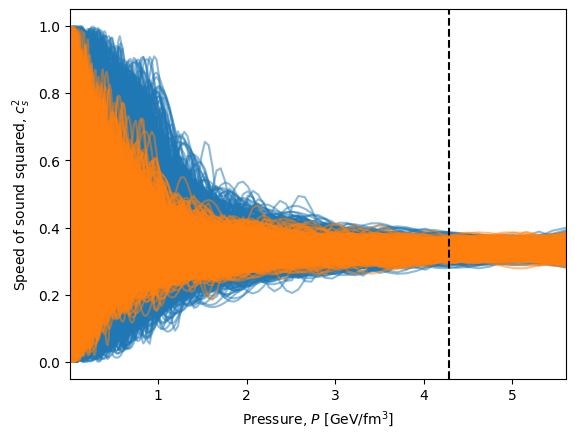

In [4]:
# Campaign numbers to compare
sets = [0, 1]

# Number of EOS draws
N = 1000

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{n:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                pressure,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i}'
                )

ax.axvline(pH, c='k', ls='--')

ax.set_xlim(min_pressure, max_pressure)

ax.set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

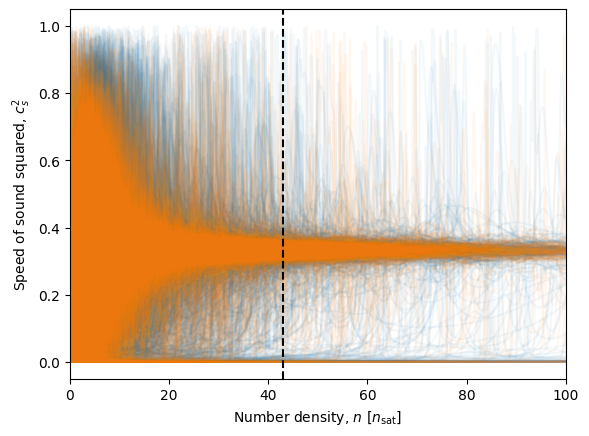

In [6]:
# Campaign numbers to compare
sets = [0, 1]

# Number of EOS draws
N = 1000

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            df = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{n:06}.csv')

            pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                number_density/nsat,
                speed_of_sound_squared, 
                alpha=0.05, 
                c=f'C{i}'
                )

ax.axvline(nH/nsat, c='k', ls='--')

ax.set_xlim(0, 100)

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

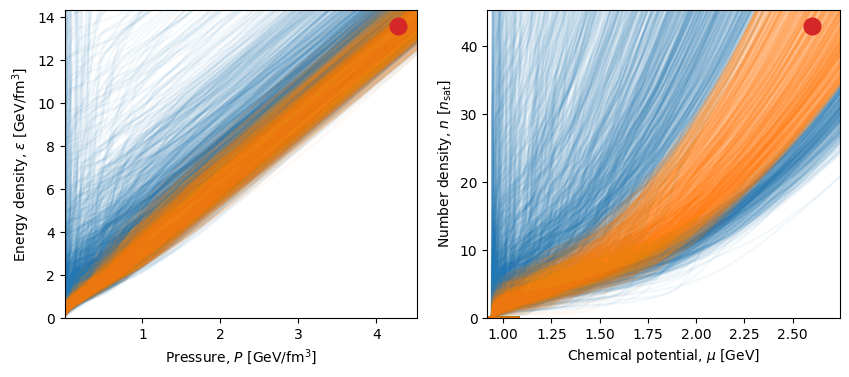

In [8]:
number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

near_EOSs = {}

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(pH, epsilonH, 'C3', marker='o', markersize=12, zorder=5)
axs[1].plot(muH, nH/nsat, 'C3', marker='o', markersize=12, zorder=5)

xlim0 = axs[0].get_xlim()
ylim0 = axs[0].get_ylim()

xlim1 = axs[1].get_xlim()
ylim1 = axs[1].get_ylim()

min_mu = muH

N_samp = 1000

for variety in ['had', 'hyp', 'qrk']:

    near_EOSs[variety] = []

    for n in range(N_samp):

        df = pd.read_csv(f'eos-draws-modified/{variety}agn/eos-draw-{n:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
        chemical_potential = (energy_density+pressure)/number_density

        if min(chemical_potential) < min_mu:
            min_mu = min(chemical_potential)

        # Build an interpolant over number density
        pressure_interp = interp1d(number_density, pressure, bounds_error=False)
        energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
        chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

        # Check we reach the pQCD pressure
        if not np.isnan(pressure_interp(nH)):

            pressure_dense = pressure_interp(number_density_array)
            energy_density_dense = energy_density_interp(number_density_array)
            chemical_potential_dense = chemical_potential_interp(number_density_array)

            # Get the part of the EOS array within 10% of the pQCD pressure
            near_eos = np.where((pressure_dense > 0.9*pH) & (pressure_dense < 1.1*pH))[0]

            # Get the EOSs that are also within 10% of the pQCD energy density
            # near_eos = near_eos[
            #     np.where(
            #         (energy_density_dense[near_eos] > 0.9*epsilonH) & 
            #         (energy_density_dense[near_eos] < 1.1*epsilonH)
            #     )[0]
            # ]

            # Get the EOSs that are also within 10% of the pQCD chemical potential
            near_eos = near_eos[
                np.where(
                    (chemical_potential_dense[near_eos] > 0.9*muH) & 
                    (chemical_potential_dense[near_eos] < 1.1*muH)
                )[0]
            ]

            if len(near_eos) > 0:
                near_EOSs[variety].append(n)

            axs[0].plot(
                pressure,
                energy_density, 
                alpha=0.05, 
                c='C0' if len(near_eos) == 0 else 'C1',
                zorder = 0 if len(near_eos) == 0 else 1
                )
            
            axs[1].plot(
                chemical_potential,
                number_density/nsat, 
                alpha=0.05, 
                c='C0' if len(near_eos) == 0 else 'C1',
                zorder = 0 if len(near_eos) == 0 else 1
                )

axs[0].set_xlim(min_pressure, xlim0[1])
axs[0].set_ylim(0, ylim0[1])

axs[1].set_xlim(min_mu, xlim1[1])
axs[1].set_ylim(0, ylim1[1])

axs[0].set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Energy density, $\epsilon$ [GeV/fm$^3]$')

axs[1].set_xlabel(r'Chemical potential, $\mu$ [GeV]')
_ = axs[1].set_ylabel(r'Number density, $n$ $[n_{\rm sat}]$')

In [9]:
for l in near_EOSs.values():
    print(len(l))

235
343
424


(0.8185820921299894, 3.5448374752987086)
(-0.28018001533245745, 5.889989222819642)


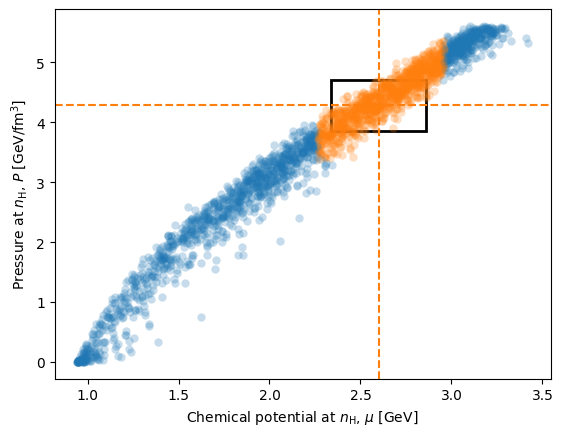

In [10]:
fig, ax = plt.subplots()
# ax.set_yscale('log')

number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

N_samp = 1000

c_dict = {'had': 'C0', 'hyp': 'C1', 'qrk': 'C2'}

for variety in ['had', 'hyp', 'qrk']:

    for n in range(N_samp):

        df = pd.read_csv(f'eos-draws-modified/{variety}agn/eos-draw-{n:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
        chemical_potential = (energy_density+pressure)/number_density

        # Build an interpolant over number density
        pressure_interp = interp1d(number_density, pressure, bounds_error=False)
        energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
        chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

        # Check we reach the pQCD pressure
        if not np.isnan(pressure_interp(nH)):

            # Get the pressure and chemical potential at nH
            pressure_nH = pressure_interp(nH)
            chemical_potential_nH = chemical_potential_interp(nH)

            ax.plot(
                chemical_potential_nH,
                pressure_nH, 
                alpha=0.25, 
                c='C0' if n not in near_EOSs[variety] else 'C1',
                marker='o',
                markeredgewidth=0,
                )   
            
ax.axhline(pH, c='C1', ls='--')
ax.axvline(muH, c='C1', ls='--')

# ax.axhline(0.9*pH, c='k', ls='--', alpha=0.25)
# ax.axvline(0.9*muH, c='k', ls='--', alpha=0.25)

from matplotlib.patches import Rectangle
ax.add_artist(
    Rectangle(
        (0.9*muH, 0.9*pH), 
        0.2*muH, 0.2*pH, 
        linewidth=2, 
        edgecolor='k', 
        facecolor='none'
    )
)

print(ax.get_xlim())
print(ax.get_ylim())

ax.set_xlabel(r'Chemical potential at $n_\mathrm{H}$, $\mu$ [GeV]')
_ = ax.set_ylabel(r'Pressure at $n_\mathrm{H}$, $P$ [GeV/fm$^3]$')

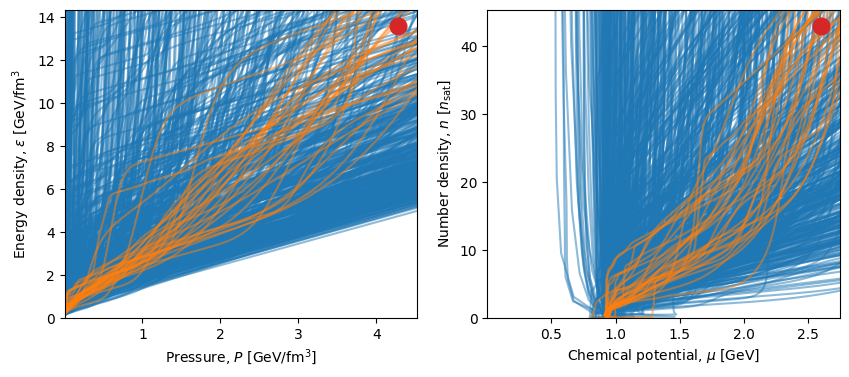

In [11]:
collated_eos = pd.read_csv('collated_np_all_post.csv')

number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

near_EOSs_default = []

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(pH, epsilonH, 'C3', marker='o', markersize=12, zorder=5)
axs[1].plot(muH, nH/nsat, 'C3', marker='o', markersize=12, zorder=5)

xlim0 = axs[0].get_xlim()
ylim0 = axs[0].get_ylim()

xlim1 = axs[1].get_xlim()
ylim1 = axs[1].get_ylim()

min_mu = muH

N_samp = 1000
for eos in collated_eos.eos[:N_samp]:

    df = pd.read_csv(f'eos-draws/eos-draw-{int(eos):06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
    chemical_potential = (energy_density+pressure)/number_density

    if min(chemical_potential) < min_mu:
        min_mu = min(chemical_potential)

    # Build an interpolant over number density
    pressure_interp = interp1d(number_density, pressure, bounds_error=False)
    energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
    chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

    # Check we reach the pQCD pressure
    if not np.isnan(pressure_interp(nH)):

        pressure_dense = pressure_interp(number_density_array)
        energy_density_dense = energy_density_interp(number_density_array)
        chemical_potential_dense = chemical_potential_interp(number_density_array)

        # Get the part of the EOS array within 10% of the pQCD pressure
        near_eos = np.where((pressure_dense > 0.9*pH) & (pressure_dense < 1.1*pH))[0]

        # Get the EOSs that are also within 10% of the pQCD energy density
        # near_eos = near_eos[
        #     np.where(
        #         (energy_density_dense[near_eos] > 0.9*epsilonH) & 
        #         (energy_density_dense[near_eos] < 1.1*epsilonH)
        #     )[0]
        # ]

        # Get the EOSs that are also within 10% of the pQCD chemical potential
        near_eos = near_eos[
            np.where(
                (chemical_potential_dense[near_eos] > 0.9*muH) & 
                (chemical_potential_dense[near_eos] < 1.1*muH)
            )[0]
        ]

        if len(near_eos) > 0:
            near_EOSs_default.append(eos)

        axs[0].plot(
            pressure,
            energy_density, 
            alpha=0.5, 
            c='C0' if len(near_eos) == 0 else 'C1',
            zorder = 0 if len(near_eos) == 0 else 1
            )
        
        axs[1].plot(
            chemical_potential,
            number_density/nsat, 
            alpha=0.5, 
            c='C0' if len(near_eos) == 0 else 'C1',
            zorder = 0 if len(near_eos) == 0 else 1
            )

axs[0].set_xlim(min_pressure, xlim0[1])
axs[0].set_ylim(0, ylim0[1])

axs[1].set_xlim(min_mu, xlim1[1])
axs[1].set_ylim(0, ylim1[1])

axs[0].set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Energy density, $\epsilon$ [GeV/fm$^3$')

axs[1].set_xlabel(r'Chemical potential, $\mu$ [GeV]')
_ = axs[1].set_ylabel(r'Number density, $n$ $[n_{\rm sat}]$')

In [12]:
len(near_EOSs_default)

32

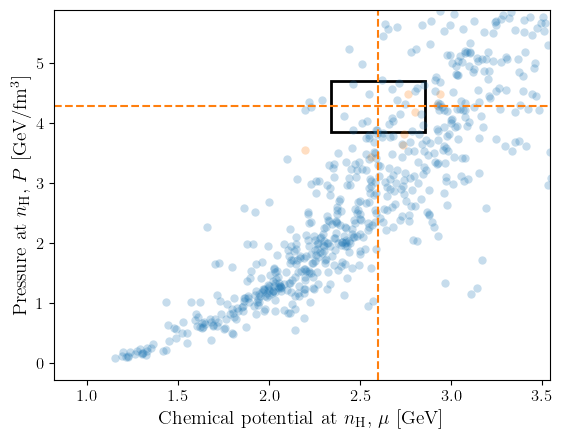

In [100]:
collated_eos = pd.read_csv('collated_eos.csv')

fig, ax = plt.subplots()
# ax.set_yscale('log')

number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

c_dict = {'had': 'C0', 'hyp': 'C1', 'qrk': 'C2'}

N_samp = 2000
for eos in collated_eos.eos[:N_samp]:

    df = pd.read_csv(f'eos-draws/eos-draw-{int(eos):06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
    chemical_potential = (energy_density+pressure)/number_density

    # Build an interpolant over number density
    pressure_interp = interp1d(number_density, pressure, bounds_error=False)
    energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
    chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

    # Check we reach the pQCD pressure
    if not np.isnan(pressure_interp(nH)):

        # Get the pressure and chemical potential at nH
        pressure_nH = pressure_interp(nH)
        chemical_potential_nH = chemical_potential_interp(nH)

        ax.plot(
            chemical_potential_nH,
            pressure_nH, 
            alpha=0.25, 
            c='C0' if eos not in near_EOSs_default else 'C1',
            marker='o',
            markeredgewidth=0,
            )   
            
ax.axhline(pH, c='C1', ls='--')
ax.axvline(muH, c='C1', ls='--')

# ax.axhline(0.9*pH, c='k', ls='--', alpha=0.25)
# ax.axvline(0.9*muH, c='k', ls='--', alpha=0.25)

from matplotlib.patches import Rectangle
ax.add_artist(
    Rectangle(
        (0.9*muH, 0.9*pH), 
        0.2*muH, 0.2*pH, 
        linewidth=2, 
        edgecolor='k', 
        facecolor='none'
    )
)

ax.set_xlim((0.8185820921299894, 3.5448374752987086))
ax.set_ylim((-0.28018001533245745, 5.889989222819642))

ax.set_xlabel(r'Chemical potential at $n_\mathrm{H}$, $\mu$ [GeV]')
_ = ax.set_ylabel(r'Pressure at $n_\mathrm{H}$, $P$ [GeV/fm$^3]$')

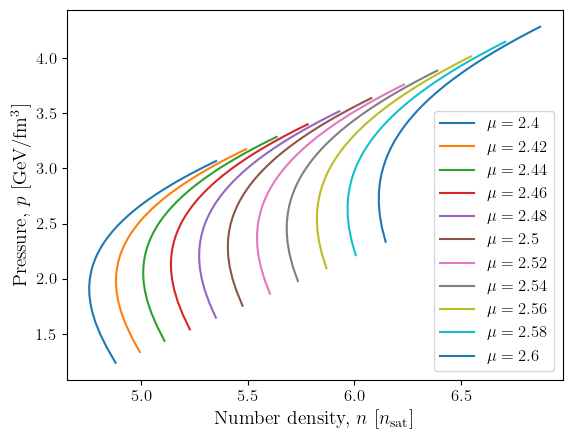

In [36]:
X_marks = [0.5, 1, 2]
mu_marks = [2.4, 2.42, 2.44, 2.46, 2.48, 2.5, 2.52, 2.54, 2.56, 2.58, 2.6]

array_resolution = 100
X_array = np.linspace(X_marks[0], X_marks[-1], array_resolution)
mu_array = np.linspace(mu_marks[0], mu_marks[-1], array_resolution)

p_arrays = []
n_arrays = []

for mu in mu_marks: 
    p_arrays.append(np.zeros(array_resolution))
    n_arrays.append(np.zeros(array_resolution))
    for i, X in enumerate(X_array):
        pQCDX = pQCD(X)
        p_arrays[-1][i] = pQCDX.pressure(mu)
        n_arrays[-1][i] = pQCDX.number_density(mu)

fig, ax = plt.subplots()

for i, mu in enumerate(mu_marks):
    ax.plot(n_arrays[i], p_arrays[i], label=fr'$\mu = {mu}$', c=f'C{i}')

ax.legend()

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

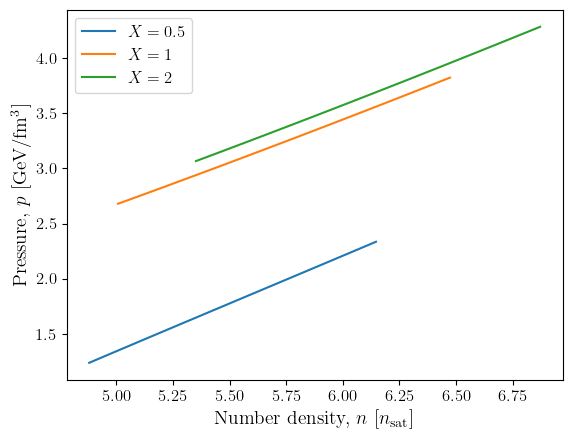

In [37]:
X_marks = [0.5, 1, 2]
mu_marks = [2.4, 2.42, 2.44, 2.46, 2.48, 2.5, 2.52, 2.54, 2.56, 2.58, 2.6]

array_resolution = 100
X_array = np.linspace(X_marks[0], X_marks[-1], array_resolution)
mu_array = np.linspace(mu_marks[0], mu_marks[-1], array_resolution)

p_arrays = []
n_arrays = []

for X in X_marks: 
    p_arrays.append(np.zeros(array_resolution))
    n_arrays.append(np.zeros(array_resolution))
    for i, mu in enumerate(mu_array):
        pQCDX = pQCD(X)
        p_arrays[-1][i] = pQCDX.pressure(mu)
        n_arrays[-1][i] = pQCDX.number_density(mu)

fig, ax = plt.subplots()

for i, X in enumerate(X_marks):
    ax.plot(n_arrays[i], p_arrays[i], label=fr'$X = {X}$', c=f'C{i}')

ax.legend()

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

In [38]:
X_boundaries = [0.5, 2]
mu_boundaries = [2.4, 2.6]

array_resolution = 100
X_array = np.linspace(*X_boundaries, array_resolution)
mu_array = np.linspace(*mu_boundaries, array_resolution)

p_boundary_arrays = []
n_boundary_arrays = []

# Get the fixed-mu arrays first
for mu in mu_boundaries:
    p_boundary_arrays.append(np.zeros(array_resolution))
    n_boundary_arrays.append(np.zeros(array_resolution))
    for i, X in enumerate(X_array):
        pQCDX = pQCD(X)
        p_boundary_arrays[-1][i] = pQCDX.pressure(mu)
        n_boundary_arrays[-1][i] = pQCDX.number_density(mu)

# Get the fixed-X arrays next
for X in X_boundaries:
    p_boundary_arrays.append(np.zeros(array_resolution))
    n_boundary_arrays.append(np.zeros(array_resolution))
    for i, mu in enumerate(mu_array):
        pQCDX = pQCD(X)
        p_boundary_arrays[-1][i] = pQCDX.pressure(mu)
        n_boundary_arrays[-1][i] = pQCDX.number_density(mu)

In [39]:
left_n_boundary = np.hstack([n_boundary_arrays[0], n_boundary_arrays[3]])
right_n_boundary = np.hstack([n_boundary_arrays[2], n_boundary_arrays[1]])

left_p_boundary = np.hstack([p_boundary_arrays[0], p_boundary_arrays[3]])
right_p_boundary = np.hstack([p_boundary_arrays[2], p_boundary_arrays[1]])

n_boundary_min = min(left_n_boundary)
n_boundary_max = max(right_n_boundary)

p_boundary_min = min(left_p_boundary)
p_boundary_max = max(right_p_boundary)

(20.899241856209166, 56.18098929351073)
(1.0183050679544774, 5.827219646694182)


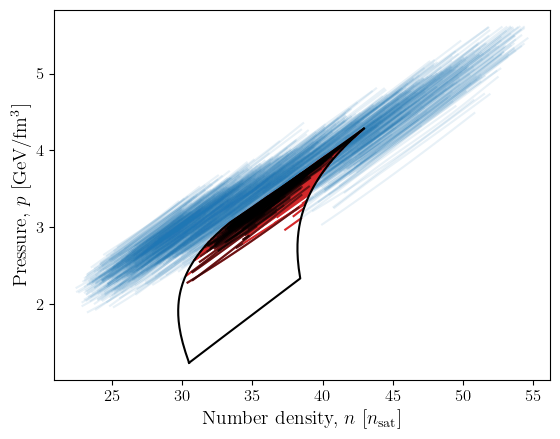

In [79]:
# Number of EOS draws
N_samp = 1000

good_EOSs = {var: [] for var in ['had', 'hyp', 'qrk']}

chemical_potential_array = np.linspace(2.4, 2.6, 100)

fig, ax = plt.subplots()

for variety in ['had', 'hyp', 'qrk']:
    for ni in range(N_samp):

        df = pd.read_csv(f'eos-draws-modified/{variety}agn/eos-draw-{ni:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

        chemical_potential = (energy_density+pressure)/number_density
        speed_of_sound_squared = np.gradient(pressure, energy_density)

        # Build an interpolant over chemical potential
        pressure_interp = interp1d(chemical_potential, pressure, bounds_error=False)(chemical_potential_array)
        energy_density_interp = interp1d(chemical_potential, energy_density, bounds_error=False)(chemical_potential_array)
        number_density_interp = interp1d(chemical_potential, number_density, bounds_error=False)(chemical_potential_array)

        # Perform a quick filter to remove EOSs that don't cross the min and max number densities
        if max(number_density_interp) < n_boundary_min or min(number_density_interp) > n_boundary_max:
            continue

        # Perform a quick filter to remove EOSs that don't cross the min and max pressures
        if max(pressure_interp) < p_boundary_min or min(pressure_interp) > p_boundary_max:
            continue

        inside_region_n = []
        inside_region_p = []
        inside_region_mu = []

        for n, p, mu in zip(number_density_interp, pressure_interp, chemical_potential_array):
            if p_boundary_min < p < p_boundary_max:
                min_n = left_n_boundary[np.argmin(np.abs(left_p_boundary-p))]
                max_n = right_n_boundary[np.argmin(np.abs(right_p_boundary-p))]
                if n > min_n and n < max_n:
                    inside_region_n.append(n)
                    inside_region_p.append(p)
                    inside_region_mu.append(mu)

        ax.plot(
            number_density_interp/nsat,
            pressure_interp, 
            alpha=0.1, 
            c='C0' if n not in near_EOSs[variety] else 'C1',
            )
        
        if len(inside_region_n) > 0:

            inside_region_n = np.array(inside_region_n)
            inside_region_p = np.array(inside_region_p)
            inside_region_mu = np.array(inside_region_mu)

            new_mu_boundaries = [min(inside_region_mu), max(inside_region_mu)]
            new_mu_array = np.linspace(*new_mu_boundaries, array_resolution)

            new_p_boundary_arrays = []
            new_n_boundary_arrays = []

            # Get the fixed-mu arrays first
            for mu in new_mu_boundaries:
                new_p_boundary_arrays.append(np.zeros(array_resolution))
                new_n_boundary_arrays.append(np.zeros(array_resolution))
                for i, X in enumerate(X_array):
                    pQCDX = pQCD(X)
                    new_p_boundary_arrays[-1][i] = pQCDX.pressure(mu)
                    new_n_boundary_arrays[-1][i] = pQCDX.number_density(mu)

            # Get the fixed-X arrays next
            for X in X_boundaries:
                new_p_boundary_arrays.append(np.zeros(array_resolution))
                new_n_boundary_arrays.append(np.zeros(array_resolution))
                for i, mu in enumerate(new_mu_array):
                    pQCDX = pQCD(X)
                    new_p_boundary_arrays[-1][i] = pQCDX.pressure(mu)
                    new_n_boundary_arrays[-1][i] = pQCDX.number_density(mu)

            new_left_n_boundary = np.hstack([new_n_boundary_arrays[0], new_n_boundary_arrays[3]])
            new_right_n_boundary = np.hstack([new_n_boundary_arrays[2], new_n_boundary_arrays[1]])

            new_left_p_boundary = np.hstack([new_p_boundary_arrays[0], new_p_boundary_arrays[3]])
            new_right_p_boundary = np.hstack([new_p_boundary_arrays[2], new_p_boundary_arrays[1]])

            new_n_boundary_min = min(new_left_n_boundary)
            new_n_boundary_max = max(new_right_n_boundary)

            new_p_boundary_min = min(new_left_p_boundary)
            new_p_boundary_max = max(new_right_p_boundary)

            new_inside_region_n = []
            new_inside_region_p = []
            new_inside_region_mu = []

            for n, p, mu in zip(inside_region_n, inside_region_p, inside_region_mu):
                if new_p_boundary_min < p < new_p_boundary_max:
                    min_n = new_left_n_boundary[np.argmin(np.abs(new_left_p_boundary-p))]
                    max_n = new_right_n_boundary[np.argmin(np.abs(new_right_p_boundary-p))]
                    if n > min_n and n < max_n:
                        new_inside_region_n.append(n)
                        new_inside_region_p.append(p)
                        new_inside_region_mu.append(mu)


            if len(new_inside_region_n) > 0:

                good_EOSs[variety].append(ni)

                ax.plot(
                    np.array(new_inside_region_n)/nsat,
                    new_inside_region_p, 
                    alpha=0.5, 
                    c='k',
                    zorder=4
                    
                )
        
            ax.plot(
                np.array(inside_region_n)/nsat,
                inside_region_p, 
                alpha=1, 
                c='C3',
                
            )

# ax.axvline(nH/nsat, c='C1', ls='--')

ax.plot(left_n_boundary/nsat, left_p_boundary, 'k', ls='-')
ax.plot(right_n_boundary/nsat, right_p_boundary, 'k', ls='-')

print(ax.get_xlim())
print(ax.get_ylim())

# ax.set_xlim(0, 100)

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

In [82]:
sum(len(good_EOSs[var]) for var in ['had', 'hyp', 'qrk'])

91

In [19]:
from utils import rcparams
from cmcrameri import cm
plt.rcParams.update(rcparams)

In [63]:
from matplotlib import text as mtext
import math

class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used

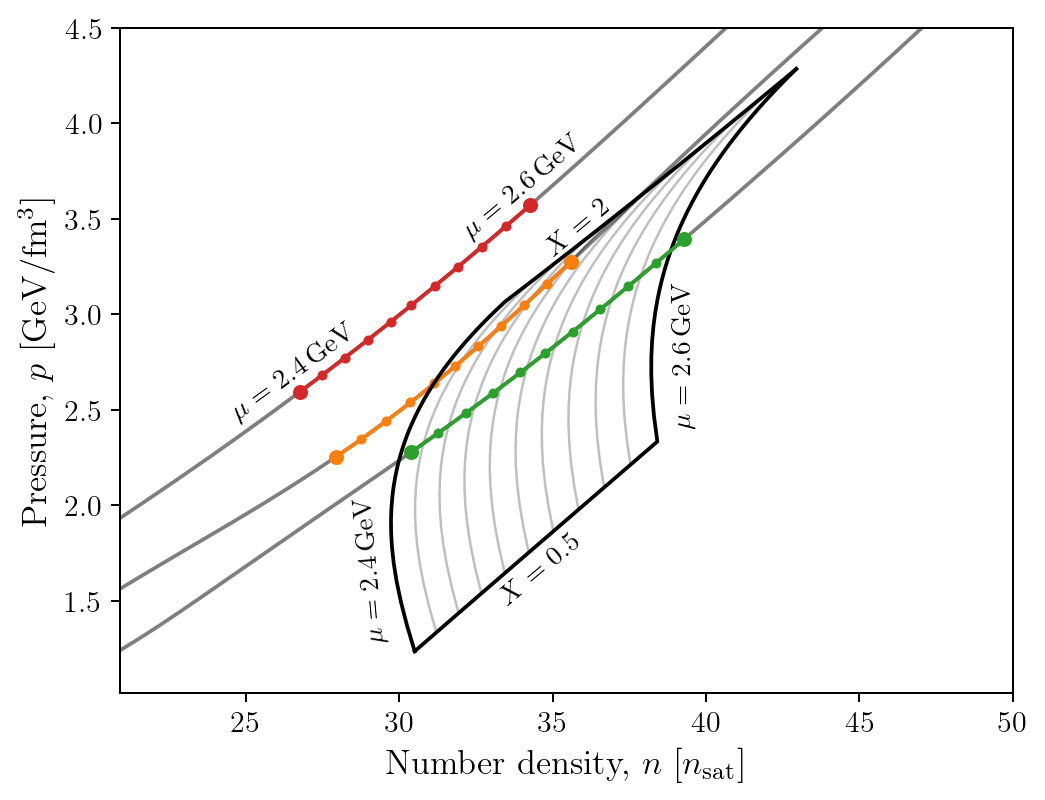

In [93]:
# Number of EOS draws
N_samp = 1000

# good_EOSs = []

chemical_potential_array = np.linspace(2.4, 2.6, 100)

mu_mark = [2.42, 2.44, 2.46, 2.48, 2.5, 2.52, 2.54, 2.56, 2.58]

fig, ax = plt.subplots(dpi=180)

for variety in ['had', 'hyp', 'qrk']:
    for ni in range(N_samp):

        df = pd.read_csv(f'eos-draws-modified/{variety}agn/eos-draw-{ni:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

        chemical_potential = (energy_density+pressure)/number_density
        speed_of_sound_squared = np.gradient(pressure, energy_density)

        # Build an interpolant over chemical potential
        pressure_interp = interp1d(chemical_potential, pressure, bounds_error=False)(chemical_potential_array)
        energy_density_interp = interp1d(chemical_potential, energy_density, bounds_error=False)(chemical_potential_array)
        number_density_interp = interp1d(chemical_potential, number_density, bounds_error=False)(chemical_potential_array)

        # Perform a quick filter to remove EOSs that don't cross the min and max number densities
        if max(number_density_interp) < n_boundary_min or min(number_density_interp) > n_boundary_max:
            continue

        # Perform a quick filter to remove EOSs that don't cross the min and max pressures
        if max(pressure_interp) < p_boundary_min or min(pressure_interp) > p_boundary_max:
            continue

        inside_region_n = []
        inside_region_p = []
        inside_region_mu = []

        for n, p, mu in zip(number_density_interp, pressure_interp, chemical_potential_array):
            if p_boundary_min < p < p_boundary_max:
                min_n = left_n_boundary[np.argmin(np.abs(left_p_boundary-p))]
                max_n = right_n_boundary[np.argmin(np.abs(right_p_boundary-p))]
                if n > min_n and n < max_n:
                    inside_region_n.append(n)
                    inside_region_p.append(p)
                    inside_region_mu.append(mu)

        if (variety == 'hyp') & (ni in [8]): # 8+np.array([0,1,2,3,4,5,6,7]):
            ax.plot(
                number_density/nsat,
                pressure,
                c='k',
                alpha=0.5,
                # linewidth=0.25,
                zorder=0.1
            )
            ax.plot(
                number_density_interp/nsat,
                pressure_interp, 
                alpha=1, 
                # linewidth=1,
                c='C3'
                )
            ax.plot(
                number_density_interp[0]/nsat,
                pressure_interp[0],
                marker='o',
                c='C3',
                markersize=5,
            )
            ax.plot(
                number_density_interp[-1]/nsat,
                pressure_interp[-1],
                marker='o',
                c='C3',
                markersize=5,
            )
            ax.text(
                number_density_interp[0]/nsat,
                pressure_interp[0]+0.05,
                '$\mu = 2.4\,\mathrm{GeV}$',
                horizontalalignment='center',
                verticalalignment='bottom',
                fontsize=11,
                rotation=36,
                rotation_mode='anchor',
            )
            ax.text(
                number_density_interp[-1]/nsat,
                pressure_interp[-1]+0.05,
                '$\mu = 2.6\,\mathrm{GeV}$',
                horizontalalignment='center',
                verticalalignment='bottom',
                fontsize=11,
                rotation=40,
                rotation_mode='anchor',
            )
            for mu in mu_mark:
                p_at_mu = pressure_interp[np.argmin(np.abs(chemical_potential_array-mu))]
                n_at_mu = number_density_interp[np.argmin(np.abs(chemical_potential_array-mu))]
                ax.plot(
                    n_at_mu/nsat,
                    p_at_mu,
                    marker='o',
                    c='C3',
                    markersize=3,
                )

        
        if len(inside_region_n) > 0:

            # if (variety == 'qrk') & (ni in [877]):
            #     ax.plot(
            #         np.array(number_density_interp)/nsat,
            #         pressure_interp, 
            #         alpha=1, 
            #         c='C3',
            #         zorder=2
            #     )

            # if pressure_interp[-1] < 4.5:
            #     print(variety, ni)

            inside_region_n = np.array(inside_region_n)
            inside_region_p = np.array(inside_region_p)
            inside_region_mu = np.array(inside_region_mu)

            new_mu_boundaries = [min(inside_region_mu), max(inside_region_mu)]
            new_mu_array = np.linspace(*new_mu_boundaries, array_resolution)

            new_p_boundary_arrays = []
            new_n_boundary_arrays = []

            # Get the fixed-mu arrays first
            for mu in new_mu_boundaries:
                new_p_boundary_arrays.append(np.zeros(array_resolution))
                new_n_boundary_arrays.append(np.zeros(array_resolution))
                for i, X in enumerate(X_array):
                    pQCDX = pQCD(X)
                    new_p_boundary_arrays[-1][i] = pQCDX.pressure(mu)
                    new_n_boundary_arrays[-1][i] = pQCDX.number_density(mu)

            # Get the fixed-X arrays next
            for X in X_boundaries:
                new_p_boundary_arrays.append(np.zeros(array_resolution))
                new_n_boundary_arrays.append(np.zeros(array_resolution))
                for i, mu in enumerate(new_mu_array):
                    pQCDX = pQCD(X)
                    new_p_boundary_arrays[-1][i] = pQCDX.pressure(mu)
                    new_n_boundary_arrays[-1][i] = pQCDX.number_density(mu)

            new_left_n_boundary = np.hstack([new_n_boundary_arrays[0], new_n_boundary_arrays[3]])
            new_right_n_boundary = np.hstack([new_n_boundary_arrays[2], new_n_boundary_arrays[1]])

            new_left_p_boundary = np.hstack([new_p_boundary_arrays[0], new_p_boundary_arrays[3]])
            new_right_p_boundary = np.hstack([new_p_boundary_arrays[2], new_p_boundary_arrays[1]])

            new_n_boundary_min = min(new_left_n_boundary)
            new_n_boundary_max = max(new_right_n_boundary)

            new_p_boundary_min = min(new_left_p_boundary)
            new_p_boundary_max = max(new_right_p_boundary)

            new_inside_region_n = []
            new_inside_region_p = []
            new_inside_region_mu = []

            for n, p, mu in zip(inside_region_n, inside_region_p, inside_region_mu):
                if new_p_boundary_min < p < new_p_boundary_max:
                    min_n = new_left_n_boundary[np.argmin(np.abs(new_left_p_boundary-p))]
                    max_n = new_right_n_boundary[np.argmin(np.abs(new_right_p_boundary-p))]
                    if n > min_n and n < max_n:
                        new_inside_region_n.append(n)
                        new_inside_region_p.append(p)
                        new_inside_region_mu.append(mu)

            if len(inside_region_n) > 0:
                if len(new_inside_region_n) == 0:
                    # if pressure_interp[-1] < 4:
                    #     p_at_30 = pressure_interp[np.argmin(np.abs(number_density_interp-30*nsat))]
                    #     print(variety, ni, p_at_30)
                    if (variety == 'qrk') & (ni in [473]):
                        ax.plot(
                            number_density/nsat,
                            pressure,
                            c='k',
                            alpha=0.5,
                            zorder=1.9
                        )
                        ax.plot(
                            number_density_interp/nsat,
                            pressure_interp, 
                            alpha=1, 
                            c='C1',
                            zorder=2
                        )
                        ax.plot(
                            number_density_interp[0]/nsat,
                            pressure_interp[0],
                            marker='o',
                            c='C1',
                            markersize=5,
                        )
                        ax.plot(
                            number_density_interp[-1]/nsat,
                            pressure_interp[-1],
                            marker='o',
                            c='C1',
                            markersize=5,
                        )
                        for mu in mu_mark:
                            p_at_mu = pressure_interp[np.argmin(np.abs(chemical_potential_array-mu))]
                            n_at_mu = number_density_interp[np.argmin(np.abs(chemical_potential_array-mu))]
                            ax.plot(
                                n_at_mu/nsat,
                                p_at_mu,
                                marker='o',
                                c='C1',
                                markersize=3,
                            )

                    

            if len(new_inside_region_n) > 0:

                # good_EOSs.append([variety, ni])

                # p_at_32 = pressure[np.argmin(np.abs(number_density-32*nsat))]
                # if p_at_32 < 2.5:
                #     print(variety, ni, p_at_32)

                if (variety == 'hyp') & (ni in [807]):
                    ax.plot(
                        number_density/nsat,
                        pressure,
                        c='k',
                        alpha=0.5,
                        zorder=2.9
                    )
                    ax.plot(
                        np.array(number_density_interp)/nsat,
                        pressure_interp, 
                        alpha=1, 
                        c='C2',
                        zorder=3
                    )
                    ax.plot(
                        number_density_interp[0]/nsat,
                        pressure_interp[0],
                        marker='o',
                        c='C2',
                        markersize=5,
                        zorder=3
                    )
                    ax.plot(
                        number_density_interp[-1]/nsat,
                        pressure_interp[-1],
                        marker='o',
                        c='C2',
                        markersize=5,
                        zorder=3
                    )
                    for mu in mu_mark:
                        p_at_mu = pressure_interp[np.argmin(np.abs(chemical_potential_array-mu))]
                        n_at_mu = number_density_interp[np.argmin(np.abs(chemical_potential_array-mu))]
                        ax.plot(
                            n_at_mu/nsat,
                            p_at_mu,
                            marker='o',
                            c='C2',
                            markersize=3,
                            zorder=3
                        )


                # ax.plot(
                #     np.array(new_inside_region_n)/nsat,
                #     new_inside_region_p, 
                #     alpha=0.5, 
                #     c='k',
                #     zorder=4
                # )
        
                # ax.plot(
                #     np.array(inside_region_n)/nsat,
                #     inside_region_p, 
                #     alpha=1, 
                #     c='C3',
                #     zorder=2
                # )

# ax.axvline(nH/nsat, c='C1', ls='--')

ax.plot(left_n_boundary/nsat, left_p_boundary, 'k', ls='-')
ax.plot(right_n_boundary/nsat, right_p_boundary, 'k', ls='-')

p_boundary_arrays = []
n_boundary_arrays = []

for mu in mu_mark:

    # Get the fixed-mu arrays first
    p_boundary_arrays.append(np.zeros(array_resolution))
    n_boundary_arrays.append(np.zeros(array_resolution))
    for i, X in enumerate(X_array):
        pQCDX = pQCD(X)
        p_boundary_arrays[-1][i] = pQCDX.pressure(mu)
        n_boundary_arrays[-1][i] = pQCDX.number_density(mu)

    ax.plot(
        n_boundary_arrays[-1]/nsat,
        p_boundary_arrays[-1], 
        alpha=0.25, 
        c='k',
        zorder=0.1,
        linewidth=1
    )

ax.text(33.5, 1.47, '$X = 0.5$', fontsize=11, rotation=40, rotation_mode='anchor')
ax.text(35, 3.3, '$X = 2$', fontsize=11, rotation=40, rotation_mode='anchor')

ax.text(29.5, 1.28, '$\mu = 2.4\,\mathrm{GeV}$', fontsize=11, rotation=95, rotation_mode='anchor')
ax.text(39.5, 2.4, '$\mu = 2.6\,\mathrm{GeV}$', fontsize=11, rotation=90, rotation_mode='anchor')

# start_index = 0
# text = CurvedText(
#     x=n_boundary_arrays[0][start_index:]/nsat,
#     y=p_boundary_arrays[0][start_index:],
#     text=r'$\mu = 2.4\,\mathrm{GeV}$',
#     va='bottom',
#     axes=ax,
#     fontsize=11
# )

ax.set_xlim((20.899241856209166, 50))
ax.set_ylim((1.0183050679544774, 4.5))

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

(-0.9130718599572827, 77.13715106050344)
(0.10070448801305942, 5.8719149244840585)


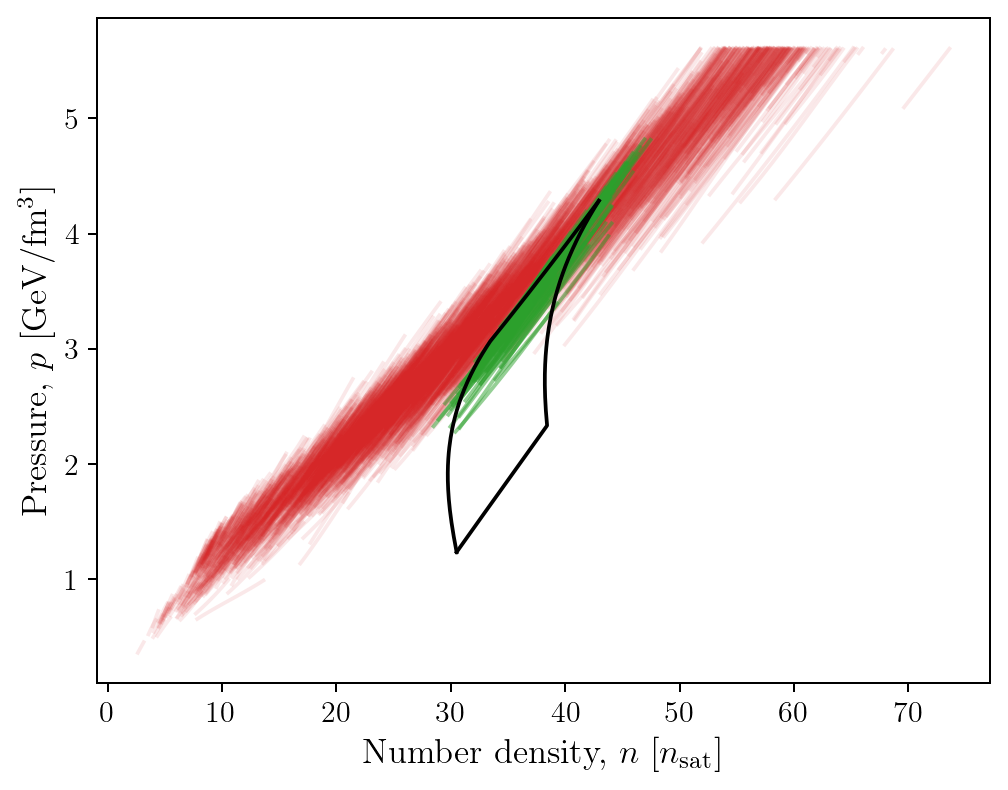

In [94]:
# Number of EOS draws
N_samp = 1000

chemical_potential_array = np.linspace(2.4, 2.6, 100)

fig, ax = plt.subplots(dpi=180)

for variety in ['had', 'hyp', 'qrk']:
    for ni in range(N_samp):

        df = pd.read_csv(f'eos-draws-modified/{variety}agn/eos-draw-{ni:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

        chemical_potential = (energy_density+pressure)/number_density
        speed_of_sound_squared = np.gradient(pressure, energy_density)

        # Build an interpolant over chemical potential
        pressure_interp = interp1d(chemical_potential, pressure, bounds_error=False)(chemical_potential_array)
        energy_density_interp = interp1d(chemical_potential, energy_density, bounds_error=False)(chemical_potential_array)
        number_density_interp = interp1d(chemical_potential, number_density, bounds_error=False)(chemical_potential_array)

        ax.plot(
            number_density_interp/nsat,
            pressure_interp, 
            alpha=0.1 if ni not in good_EOSs[variety] else 0.5, 
            c='C3' if ni not in good_EOSs[variety] else 'C2',
            zorder=1 if ni not in good_EOSs[variety] else 2
            )

ax.plot(left_n_boundary/nsat, left_p_boundary, 'k', ls='-', zorder=3)
ax.plot(right_n_boundary/nsat, right_p_boundary, 'k', ls='-', zorder=3)

print(ax.get_xlim())
print(ax.get_ylim())

# ax.set_xlim((20.899241856209166, 50))
# ax.set_ylim((1.0183050679544774, 4.5))

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

In [92]:
sum(len(good_EOSs[var]) for var in ['had', 'hyp', 'qrk'])

91

In [77]:
good_EOSs[-5:]

[839, 866, 877, 970, 987]

In [ ]:
from functools import lru_cache

@lru_cache()
def get_boundary_arrays(mu_low, mu_high, X_low, X_high, array_resolution=100):

    mu_boundaries = [mu_low, mu_high]
    X_boundaries = [X_low, X_high]

    p_boundary_arrays = []
    n_boundary_arrays = []

    # Get the fixed-mu arrays first
    for mu in mu_boundaries:
        p_boundary_arrays.append(np.zeros(array_resolution))
        n_boundary_arrays.append(np.zeros(array_resolution))
        for i, X in enumerate(X_boundaries):
            pQCDX = pQCD(X)
            p_boundary_arrays[-1][i] = pQCDX.pressure(mu)
            n_boundary_arrays[-1][i] = pQCDX.number_density(mu)

    # Get the fixed-X arrays next
    for X in X_boundaries:
        p_boundary_arrays.append(np.zeros(array_resolution))
        n_boundary_arrays.append(np.zeros(array_resolution))
        for i, mu in enumerate(mu_boundaries):
            pQCDX = pQCD(X)
            p_boundary_arrays[-1][i] = pQCDX.pressure(mu)
            n_boundary_arrays[-1][i] = pQCDX.number_density(mu)

    left_n_boundary = np.hstack([n_boundary_arrays[0], n_boundary_arrays[3]])
    right_n_boundary = np.hstack([n_boundary_arrays[2], n_boundary_arrays[1]])

    left_p_boundary = np.hstack([p_boundary_arrays[0], p_boundary_arrays[3]])
    right_p_boundary = np.hstack([p_boundary_arrays[2], p_boundary_arrays[1]])

    return left_n_boundary, right_n_boundary, left_p_boundary, right_p_boundary

In [ ]:
def get_inside_region(number_density, pressure, chemical_potential, 
                      mu_boundaries, X_boundaries, array_resolution=100):

    left_n_boundary, right_n_boundary, left_p_boundary, right_p_boundary = \
        get_boundary_arrays(mu_boundaries[0], mu_boundaries[1], X_boundaries[0], X_boundaries[1], array_resolution)

    n_boundary_min = min(left_n_boundary)
    n_boundary_max = max(right_n_boundary)

    p_boundary_min = min(left_p_boundary)
    p_boundary_max = max(right_p_boundary)

    inside_region_n = []
    inside_region_p = []
    inside_region_mu = []

    for n, p, mu in zip(number_density, pressure, chemical_potential):
        if p_boundary_min < p < p_boundary_max:
            if n_boundary_min < n < n_boundary_max:
                inside_region_n.append(n)
                inside_region_p.append(p)
                inside_region_mu.append(mu)

    inside_region_n = np.array(inside_region_n)
    inside_region_p = np.array(inside_region_p)
    inside_region_mu = np.array(inside_region_mu)

    return inside_region_n, inside_region_p, inside_region_mu

In [ ]:
fig, ax = plt.subplots()

# Number of EOS draws
N_samp = 1000

good_EOSs = []

mu_boundaries = [2.4, 2.6]
X_boundaries = [0.5, 2]

left_n_boundary, right_n_boundary, left_p_boundary, right_p_boundary = \
    get_boundary_arrays(mu_boundaries[0], mu_boundaries[1], X_boundaries[0], X_boundaries[1])

ax.plot(left_n_boundary/nsat, left_p_boundary, 'k', ls='--', zorder=10)
ax.plot(right_n_boundary/nsat, right_p_boundary, 'k', ls='-', zorder=10)

array_resolution = 100
chemical_potential_array = np.linspace(*mu_boundaries, array_resolution)

for variety in ['had', 'hyp', 'qrk']:
    for ni in range(N_samp):

        df = pd.read_csv(f'eos-draws-modified/{variety}agn/eos-draw-{ni:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

        chemical_potential = (energy_density+pressure)/number_density

        # ax.plot(
        #     number_density/nsat,
        #     pressure,
        #     alpha=1,
        #     c='C0',
        #     zorder=0.1,
        #     linewidth=0.5
        # )

        # Build an interpolant over chemical potential
        pressure_interp = np.interp(chemical_potential_array, chemical_potential, pressure, left=np.nan, right=np.nan)
        energy_density_interp = np.interp(chemical_potential_array, chemical_potential, energy_density, left=np.nan, right=np.nan)
        number_density_interp = np.interp(chemical_potential_array, chemical_potential, number_density, left=np.nan, right=np.nan)

        ax.plot(
            number_density_interp/nsat,
            pressure_interp,
            alpha=1,
            c='C0',
            zorder=0.2,
            linewidth=1
        )

        # Perform a quick filter to remove EOSs that don't cross the min and max number densities
        if max(number_density_interp) < n_boundary_min or min(number_density_interp) > n_boundary_max:
            continue

        # Perform a quick filter to remove EOSs that don't cross the min and max pressures
        if max(pressure_interp) < p_boundary_min or min(pressure_interp) > p_boundary_max:
            continue

        inside_region_n, inside_region_p, inside_region_mu = get_inside_region(
            number_density_interp, pressure_interp, chemical_potential_array, mu_boundaries, X_boundaries
        )
        
        if len(inside_region_n) > 0:

            new_mu_boundaries = [min(inside_region_mu), max(inside_region_mu)]

            new_inside_region_n, new_inside_region_p, new_inside_region_mu = get_inside_region(
                inside_region_n, inside_region_p, inside_region_mu, new_mu_boundaries, X_boundaries
            )

            if len(new_inside_region_n) > 0:

                good_EOSs.append(ni)

                ax.plot(
                    new_inside_region_n/nsat,
                    new_inside_region_p, 
                    alpha=0.05, 
                    c='C1',
                    zorder=0.3
                )
        
            # ax.plot(
            #     np.array(inside_region_n)/nsat,
            #     inside_region_p, 
            #     alpha=1, 
            #     c='C3',
                
            # )

# ax.axvline(nH/nsat, c='C1', ls='--')

# ax.set_xlim(0, 100)

ax.set_xlabel(r'Number density, $n$ $[n_{\rm sat}]$')
_ = ax.set_ylabel(r'Pressure, $P$ [GeV/fm$^3$]')

In [ ]:
len(good_EOSs)